In [1]:
import matplotlib.pyplot as plt
import torch
import ehc_sn as ehc

In [2]:
from ipywidgets import interact, IntSlider, FloatSlider
from functools import partial

IntSlider = partial(IntSlider, continuous_update=False)
FloatSlider = partial(FloatSlider, continuous_update=False)

In [3]:
class Model(ehc.Network):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.wie_acc = []

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Excitatory layer dynamics
        xee = self.layers["excitatory"].nodes[0] @ self.w["excitatory"]["excitatory"].T
        xie = self.layers["inhibitory"].nodes[0] @ self.w["inhibitory"]["excitatory"].T
        x_e, cell = x + xee - xie, self.layers["excitatory"].cell
        self.layers["excitatory"].nodes = cell(x_e, self.layers["excitatory"].nodes[1])
        # Inhibitory layer dynamics
        xei = self.layers["excitatory"].nodes[0] @ self.w["excitatory"]["inhibitory"].T
        xii = self.layers["inhibitory"].nodes[0] @ self.w["inhibitory"]["inhibitory"].T
        x_i, cell = xei - xii, self.layers["inhibitory"].cell
        self.layers["inhibitory"].nodes = cell(x_i, self.layers["inhibitory"].nodes[1])
        # Update the synaptic weights
        self.plasticity("inhibitory", "excitatory")
        # Call the callback
        self.callback()
        # Return the excitatory layer output
        return self.layers["excitatory"].nodes[0]

    def callback(self):
        self.wie_acc.append(self.w["inhibitory"]["excitatory"].clone())

In [4]:
import tomllib as toml

with open("configurations/experiment_20250312.toml", "rb") as f:
    data = toml.load(f)

In [5]:
def plot_raster(spikes, title):
    plt.figure(figsize=(10, 5))
    for neuron_idx in range(spikes.shape[1]):
        spike_times = torch.nonzero(spikes[:, neuron_idx]).squeeze()
        plt.scatter(spike_times, neuron_idx * torch.ones_like(spike_times), s=1)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Neuron Index")
    plt.xlim(0, spikes.shape[0])
    plt.ylim(0, spikes.shape[1])
    plt.show()

In [6]:
model = Model(p=ehc.NetworkParameters.model_validate(data))
model = torch.compile(model)
model.eval()

OptimizedModule(
  (_orig_mod): Model()
)

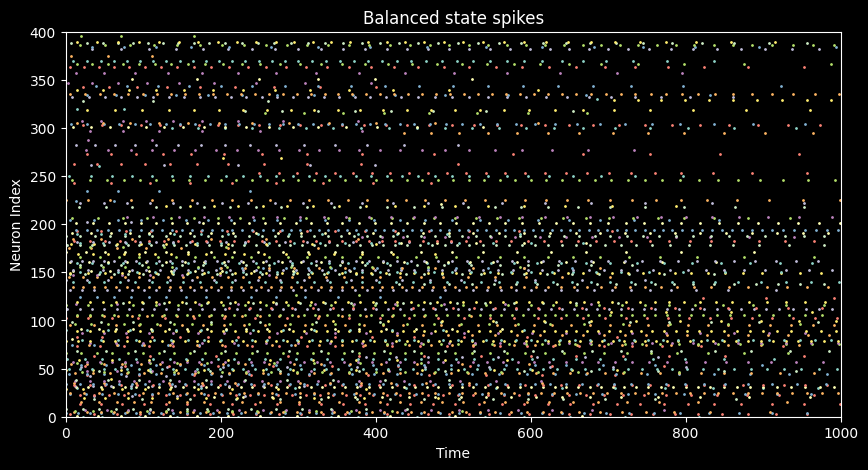

In [38]:
input_current = torch.zeros(1000, model.layers["excitatory"].population).to(ehc.device)
input_current[:, :200] = 1.0  # Apply current to the first neuron
# model.reset()
with torch.no_grad():
    outputs = model.run(input_current)
plot_raster(outputs.to("cpu"), "Balanced state spikes")

In [36]:
def plot_weights(wie_acc, title):
    plt.figure(figsize=(10, 5))
    plt.plot(wie_acc.to("cpu").numpy())
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Synaptic Weight")
    plt.show()

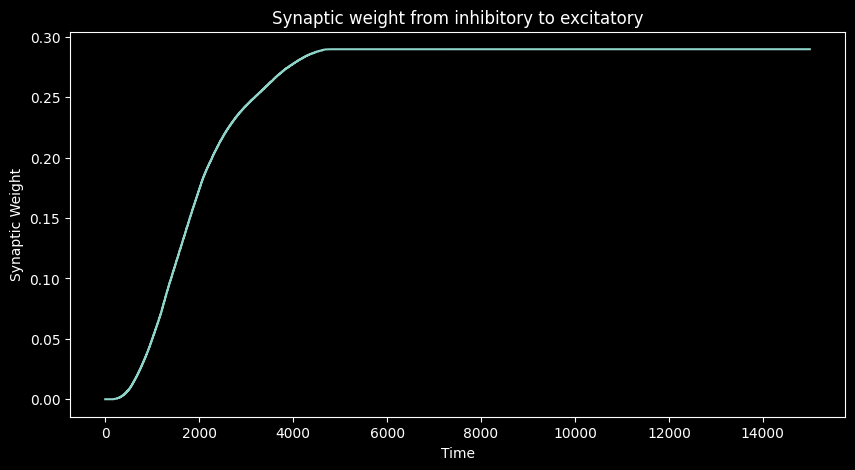

In [39]:
wie_acc = torch.stack(model.wie_acc)
plot_weights(wie_acc[:, 0, 0], "Synaptic weight from inhibitory to excitatory")